Since the file is too big, I can't print the file with the results !

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
main_datasets_path = '/content/drive/MyDrive/Colab Notebooks/LSMA/Homework2/'

# Step #1: The Descriptor – A 3D RGB Color Histogram

Basically, we will follow the code of the lab.

In [ ]:
# import the necessary packages
import numpy as np
import cv2

class RGBHistogram:
    def __init__(self, bins):
        # store the number of bins the histogram will use
        self.bins = bins

    def describe(self, image):
        # compute a 3D histogram in the RGB colorspace,
        # then normalize the histogram so that images
        # with the same content, but either scaled larger
        # or smaller will have (roughly) the same histogram
        hist = cv2.calcHist([image], [0, 1, 2],
                            None, self.bins, [0, 256, 0, 256, 0, 256])
        hist = cv2.normalize(hist, hist)

        # return out 3D histogram as a flattened array
        return hist.flatten()

# Step #2: Indexing our Dataset

In [ ]:
# import the necessary packages
import pickle
import glob
import os

# Data names and locations
dataset_location = main_datasets_path + "jpg"
index_name = "rgb_histogram_index"

# initialize the index dictionary to store our our quantified
# images, with the 'key' of the dictionary being the image
# filename and the 'value' our computed features
index = {}

# initialize our image descriptor -- a 3D RGB histogram with
# 8 bins per channel
desc = RGBHistogram([8, 8, 8])
count = 0

# use glob to grab the image paths and loop over them
for imagePath in glob.glob(dataset_location + os.sep + "*.jpg"):
    if count >= 1000: #we reduce the data_base used
        break

    # extract our unique image ID (i.e. the filename)
    k = imagePath[imagePath.rfind(os.sep) + 1:]

    # load the image, describe it using our RGB histogram
    # descriptor, and update the index
    image = cv2.imread(imagePath)
    features = desc.describe(image)
    index[k] = features

    count += 1

# we are now done indexing our image -- now we can write our
# index to disk
outputFile = open(index_name + ".pkl", "wb")
pickle.dump(index, outputFile)
outputFile.close()

# show how many images we indexed
print("done...indexed %d images" % (len(index)))


done...indexed 1000 images


# Step #3: The Search

In [ ]:
class Searcher:
    def __init__(self, index):
        # store our index of images
        self.index = index

    def search(self, queryFeatures):
        # initialize our dictionary of results
        results = {}

        # loop over the index
        for (k, features) in self.index.items():
            # compute the Euclidean distance between the features
            d = self.euclidean_distance(features, queryFeatures)

            # now that we have the distance between the two feature
            # vectors, we can udpate the results dictionary -- the
            # key is the current image ID in the index and the
            # value is the distance we just computed, representing
            # how 'similar' the image in the index is to our query
            results[k] = d

        # sort our results, so that the smaller distances (i.e. the
        # more relevant images are at the front of the list)
        results = sorted([(v, k) for (k, v) in results.items()])

        # return our results
        return results

    def euclidean_distance(self, histA, histB): #we change the method. Using the euclidean distance calculation.
        # compute the Euclidean distance
        d = np.sqrt(np.sum((histA - histB) ** 2))

        # return the Euclidean distance
        return d

# Step #4: Performing a Search

In [ ]:
# import the necessary packages
import matplotlib.pyplot as plt
%matplotlib inline

# load the index and initialize our searcher
dataset_location = main_datasets_path+"jpg"
index_name = "rgb_histogram_index"

file = open(index_name +".pkl", 'rb')
index = pickle.load(file)
searcher = Searcher(index)

# loop over images in the index -- we will use each one as
# a query image
for (query, queryFeatures) in index.items():
    # perform the search using the current query
    results = searcher.search(queryFeatures)

    # load the query image and display it
    path = dataset_location + os.sep + query
    queryImage = cv2.imread(path)
    plt.figure()
    plt.title("Query")
    b, g, r = cv2.split(queryImage)
    queryImage = cv2.merge((r, g, b))
    plt.imshow(queryImage)
    print("query: %s" % (query))

    # initialize the two montages to display our results
    montageA = np.zeros((500 * 5, 667, 3), dtype="uint8")
    montageB = np.zeros((500 * 5, 667, 3), dtype="uint8")

    # loop over the top ten results
    for j in range(0, 10):
        # grab the result (we are using row-major order) and
        # load the result image
        (score, imageName) = results[j]
        path = dataset_location + os.sep + "%s" % (imageName)
        result = cv2.imread(path)
        print("\t%d. %s : %.3f" % (j + 1, imageName, score))
        # resize the result image to fit the montage
        result = cv2.resize(result, (667, 500))
        # check to see if the first montage should be used
        if j < 5:
          montageA[j * 500:(j + 1) * 500, :] = result
          # otherwise, the second montage should be used
        else:
          montageB[(j - 5) * 500:((j - 5) + 1) * 500, :] = result

# show the results
plt.figure()
plt.title("Results 1-5")
b, g, r = cv2.split(montageA)
montageA = cv2.merge((r, g, b))
plt.imshow(montageA)
plt.figure()
plt.title("Results 6-10")
b, g, r = cv2.split(montageB)
montageB = cv2.merge((r, g, b))
plt.imshow(montageB)

Finally, the code displays the two montages using matplotlib, with the first montage showing results 1-5 and the second montage showing results 6-10.

External Queries

Query Image: /content/drive/MyDrive/Colab Notebooks/LSMA/Homework2/jpg/image_08185.jpg
	1. image_08185.jpg: 0.513
	2. image_08103.jpg: 0.669
	3. image_07364.jpg: 0.721
	4. image_07627.jpg: 0.774
	5. image_07550.jpg: 0.781
	6. image_07411.jpg: 0.783
	7. image_07824.jpg: 0.802
	8. image_07314.jpg: 0.815
	9. image_08161.jpg: 0.815
	10. image_07882.jpg: 0.819


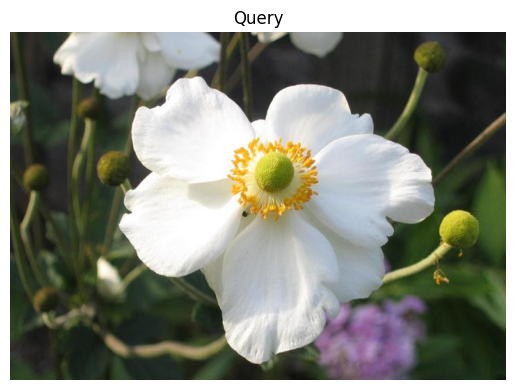

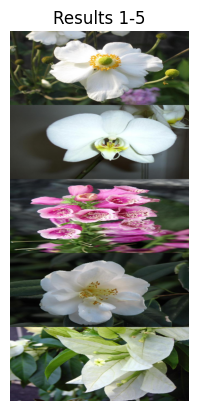

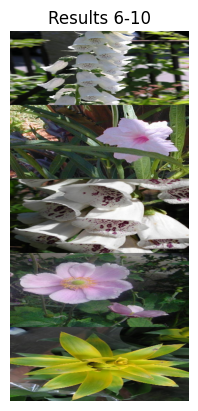

In [ ]:
# Put your own image, as example we have a folder with two images:
query_location = main_datasets_path + "jpg" + os.sep + "image_08185.jpg"

# Load the query image and show it
queryImage = cv2.imread(query_location)
queryImage = cv2.cvtColor(queryImage, cv2.COLOR_BGR2RGB)  # Convert to RGB for correct display
plt.figure()
plt.title("Query")
plt.imshow(queryImage)
plt.axis('off')
print("Query Image:", query_location)

# Load the index and perform the search
file = open(index_name + ".pkl", 'rb')
index = pickle.load(file)
searcher = Searcher(index)
queryFeatures = desc.describe(queryImage)
results = searcher.search(queryFeatures)

# Initialize the two montages to display our results --
# We have a total of 1000 images in the index, but let's only
# display the top 10 results; 5 images per montage
montageA = np.zeros((166 * 5, 400, 3), dtype="uint8")
montageB = np.zeros((166 * 5, 400, 3), dtype="uint8")

# Loop over the top ten results
for j in range(0, min(10, len(results))):
    # Grab the result and load the result image
    (score, imageName) = results[j]
    path = dataset_location + os.sep + imageName
    result = cv2.imread(path)
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)  # Convert to RGB for correct display
    print("\t{}. {}: {:.3f}".format(j + 1, imageName, score))

    # Resize the result image to match the montage size
    result = cv2.resize(result, (400, 166))

    # Check to see if the first montage should be used
    if j < 5:
        montageA[j * 166:(j + 1) * 166, :] = result
    # Otherwise, the second montage should be used
    else:
        montageB[(j - 5) * 166:((j - 5) + 1) * 166, :] = result

# Show the results
plt.figure()
plt.title("Results 1-5")
plt.imshow(montageA)
plt.axis('off')

plt.figure()
plt.title("Results 6-10")
plt.imshow(montageB)
plt.axis('off')

plt.show()


What we can conclude is the following:
The images loaded via Google are much more correlated to the image we select than the images loaded via our database.